<a href="https://colab.research.google.com/github/zvdv/RL/blob/main/Intro_to_RL_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Reinforcement Learning

So, we got through week one, where we talked about the environment and (more importantly for our purposes) the framework and foundation for our agents. In Week 2, we talked about how our agents percieve, communicate and learn from it's environment. Today, we're going to put it all into practice by implementing it all in a very simple environment.

Most of the code has already been provided, this is to minimize the number of errors we may have when dealing with code that is broadly irrelevant to what our subject matter is. We'll still cover it, and I'll try to go slow as we progress through the code.

First things first, we'll import everything we need up front.

In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
Display().start()

from IPython import display
%matplotlib inline

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import tqdm
import time as time

We'll then make the environment. Thankfully, we don't have to create it from scratch. OpenAI created an environment interface with examples from which we can learn and properly practice RL. So, we'll utilize their work.

In [3]:
# Creation of our environment.
env = gym.make("Taxi-v3")

# Let's take a look at our observation space.
env.observation_space

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Discrete(500)

So how do we interpret this weird thing above?

Where a box is some datastructure that describes the space we're working in. It details how many dimentions we're working in and what the bounds are.

In this case, we have 1 dimention we're working with, which may seem counter intuitive at first, but the gym webpage tells us why this is the case:



> An observation is returned as an int() that encodes the corresponding state, calculated by ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination.

> Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.





In [6]:
# Action space
env.action_space

Discrete(6)

So our action space is quite small: move left, right, up, down, pick up and drop off passenger.

## Preprocessing our Environment

We discussed Q-learning works with Q-tables, what that effectively means is our process of learning is entirely in the domain of Q-values and we don't really touch Values of states. Which is fine, because realisitcally we can approximate how good our state is with our Q-values from that state (as we mentioned last time).

Recall our Q-function $$Q(s, a)$$

This implies that whatever it is that results from this function relies on the state and action.

Since we're using Q-tables, we have to create all combinations of state-action pairs.

In [7]:
OBSERVATION_SPACE = 500
ACTION_SPACE = 6

print(OBSERVATION_SPACE)

500


### Hyperparameters and Book-keeping

Ideally, we'd want to create some variables that are dedicated to keeping track of the progress of our environment, as well as some variables dedicated to keeping track of what our hyperparameters are when run. So, let's do that.

In [8]:
# Book-keeping
list_ep_rewards = []

# Hyperparams
EPSILON = 0.1 #should be between 0-1 always
DISCOUNT = 0.1 #typically between 0-1 but less strict

Okay, so now we have some hyperparameters set up, we want to set up our Q-table.

Remember, our Q-table has to have all of our possible state-action pairs accounted for. This means, from every single state, we want to have a distinct value we can take for any single possible action.

At first, it doesn't matter what that value is (as long as it's not too big/weird. Why would this be the case?) so we can randomly initialize these values.



In [10]:
# Q-Table Creation
Q_table = np.random.rand(OBSERVATION_SPACE, ACTION_SPACE) #randomly initialise between 0-1

Ok, so we've done all the preliminary steps, now we're going to want to have some idea for how the environment works.

In [11]:
# Reset the environment to make sure it can run at all
obs = env.reset() #make us start in a random state

Let's just sample some random moves from the environment and check what happens, kind of a way to see what we're up against.

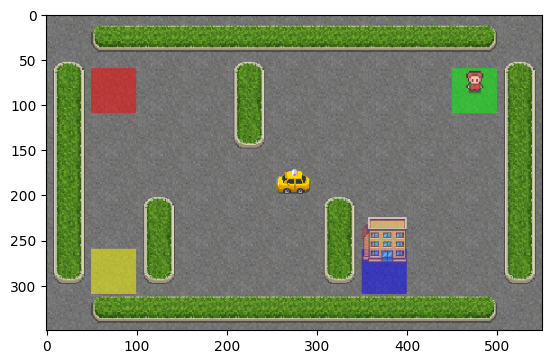

In [14]:
img = plt.imshow(env.render('rgb_array')) # only call this once

for e in range(10):
    img.set_data(env.render('rgb_array')) # just update the data

    # This is stuff needed for the display data. Don't worry about this.
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

    # Let's do some random actions!
    action = env.action_space.sample() #pick random action from our action space
    obs, reward, dones, info = env.step(action) #take a step in our environment using this action

    #obs is state
    #reward
    #dones is boolean
    #info is metadata

    # Reset if done
    if dones == True:
      env.reset()

# Closing our environment.
env.close()

So here we can see our environment take random actions, not using our Q-table whatsoever, just making sure the environment runs fine. Now that we know it does, let's try to utilize our q-table!

[(4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644), (4, 0.7154648821053644)]


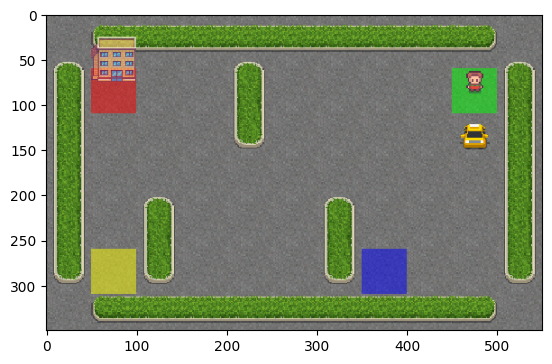

In [17]:
# We closed our environment before, so we need to reinitialze it.
obs = env.reset()

# Store our actions and their values
action_values = []

img = plt.imshow(env.render('rgb_array')) # only call this once

for e in range(10):
    # This is stuff needed for the display data. Don't worry about this.
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)

    # Let's try to pick what our q-table says our best action is.
    action = np.argmax(Q_table[obs])
    obs, reward, dones, info = env.step(action)

    # It would be nice to see what our best action is hey?
    action_values.append( (action, Q_table[obs][action]) ) #append a tuple to the action_values array

    # Reset if done
    if dones == True:
      env.reset()

# Closing our environment.
env.close()

# Print out our actions and their associated q-values
print(action_values)

Alright, so now let's train the thing.

If you remember from last time, I put the wrong formula for our update step on the slides. In actuality, our update step looks like this
$$Q(s_t, a_t) ← Q(s_t, a_t) + ᵧ(r_t + argmax_a(Q(s_{t+1}, a)) - Q(s_t, a_t))$$

This is very much just like a supervised learning problem, where we're trying to find out how wrong we are every step of the way. The way to read this as follows:

We update our Q_value at time t, $$Q(s_t, a_t)$$ which is supposed to be our prediction for how good that move was supposed to be, by seeing how good our move actually was in the immediate term $$r_t$$ as well as how good the best move is from our next state $$argmax_a(Q(s_{t+1}, a))$$ This combination of terms is our "true" value for how good the state is, so we compare it directly to our current Q-value to see how wrong we are.


How wrong we are: $$r_t + argmax_a(Q(s_{t+1}, a)) - Q(s_t, a_t)$$

Then we update with respect to a discount function.

So let's see if we can implement that.

[(2, 0.9806908531819073, 0.8806908531819073), (2, 0.8806908531819073, 0.7806908531819073), (3, 0.8211846974578775, 0.8713162593705637), (3, 0.8713162593705637, 0.7713162593705637), (2, 0.8543569130167424, 0.7806908531819073), (2, 0.7806908531819073, 0.6806908531819074), (3, 0.7261978536491461, 0.7713162593705637), (1, 0.8368609090247013, 0.2026714539847958), (3, 0.8900144810867301, 0.387590203887905), (4, 0.5105806404624247, -0.4894193595375753)]


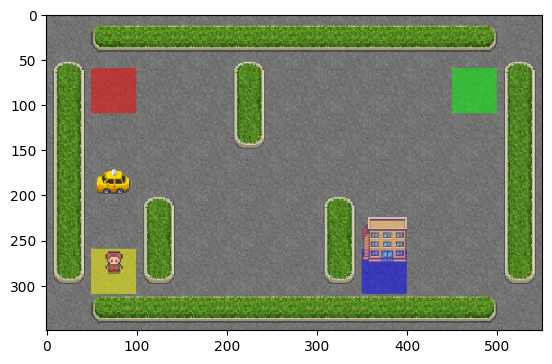

In [20]:
# We closed our environment before, so we need to reinitialze it.
obs = env.reset()

# Store our actions and their values
action_values = []

img = plt.imshow(env.render('rgb_array')) # only call this once

for e in range(10):
    ### This is stuff needed for the display data. Don't worry about this, but also don't touch it please :)
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)
    ###

    # We want to keep track of our previous state. Why?
    prev_obs = obs

    # Let's try to pick what our q-table says our best action is.
    action = np.argmax(Q_table[obs])
    obs, reward, dones, info = env.step(action)

    # Store our action and their previous values before we update anything
    Q_value = Q_table[prev_obs][action] #bookeeping

    # Update our Q values
    target = reward + np.max(Q_table[obs]) - Q_table[prev_obs][action]
    Q_table[prev_obs][action] += DISCOUNT*target

    # Check and store our new q values
    action_values.append( (action, Q_value, Q_table[obs][action]) )

    # Reset if done
    if dones == True:
      env.reset()

# Closing our environment.
env.close()

# print out our actions, and q-values before and after the update
print(action_values)

Alright so we see some changes here, which is good! Now let's send this thing into a training run!

In [21]:
# More hyper parameters
NO_EPISODES = 10000
MAX_EP_LENGTH = 200

# and we already have epsilon set up from way back when, so it's cool.

Alright, training block!

In [22]:
obs = env.reset()

for episode in tqdm.tqdm(range(NO_EPISODES)):
    # Book keeping!
    ep_reward = 0.0
    ep_length = 0.0

    while dones == False and ep_length < MAX_EP_LENGTH:
        # Keep track of prev observation
        prev_obs = obs

        # Random roll of the dice!
        random = np.random.rand()

        # Explore vs Expliot rule!
        if random > EPSILON:
          action = env.action_space.sample()
        else:
          action = np.argmax(Q_table[obs])

        obs, reward, dones, info = env.step(action)

        # Change Q-table value:
        target = reward + np.max(Q_table[obs]) - Q_table[prev_obs][action]
        Q_table[prev_obs][action] += DISCOUNT*target

        # Book-keeping
        ep_reward += reward
        ep_length += 1

    # Reset episode
    obs = env.reset()
    dones = False

    # Iteratively change EPSILON
    if EPSILON < 0.9:
      EPSILON += 0.05

    # Book-keeping
    list_ep_rewards.append(ep_reward)

# Close env
env.close()

100%|██████████| 10000/10000 [00:10<00:00, 961.57it/s]


In [23]:
# Calculating moving average, honestly I just copied this from somewhere and edited it minorly.
# Don't worry too much about this
window_size = 30

i = 0
# Initialize an empty list to store moving averages
moving_averages = []

moving_averages.append(list_ep_rewards[0])

# Loop through the array t o
#consider every window of size 3
while i < len(list_ep_rewards) - window_size + 1:

    # Calculate the average of current window
    window_average = round(np.sum(list_ep_rewards[
      i:i+window_size]) / window_size, 2)

    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)

    # Shift window to right by one position
    i += 1

moving_averages.append(list_ep_rewards[-1])

A good method of keeping track of our progress through an environment is keeping track of the rewards. So, let's print out our rewards

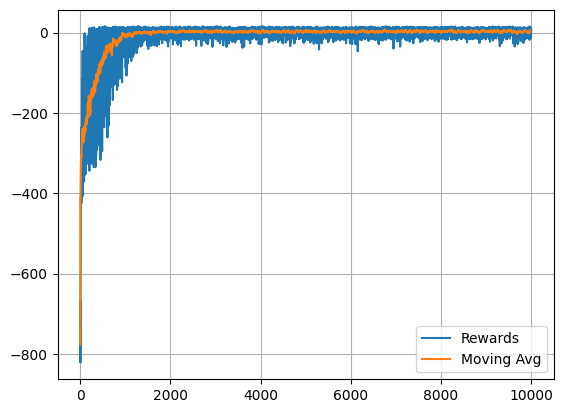

In [25]:
plt.plot(list_ep_rewards, label="Rewards")
plt.plot(moving_averages, label="Moving Avg")
plt.grid()
plt.legend()
plt.show()

Now let's test it again!

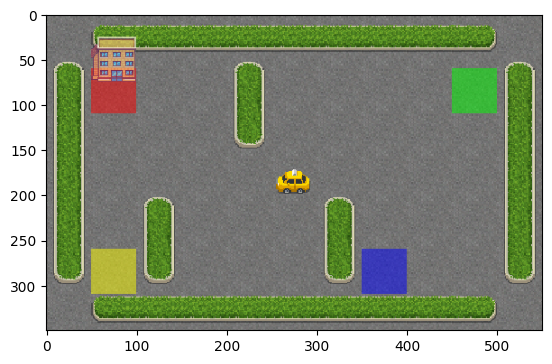

In [26]:
# Reset the environment
obs = env.reset()

img = plt.imshow(env.render('rgb_array')) # only call this once

for e in range(100):

    ### This is stuff needed for the display data. Don't worry about this, but also don't touch it please :)
    img.set_data(env.render('rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)
    ###
    # Don't need to keep track of prev obs because we are just exploiting now

    # Fully exploit our environment
    action = np.argmax(Q_table[obs]) #pick "best" action every time now because it should be optimised after training

    # Take our step
    obs, reward, dones, info = env.step(action)


    # Reset if done
    if dones == True:
      obs = env.reset()


# Close our environment
env.close()

And that's pretty much it! This method can be used for many other gym environments as well so if you're keen, you can pick a more interesting/difficult environment to try this on.

Please feel free to stay and ask questions, play around with the parameters, or whatnaught.

Cheers!

-UVicAI